# Draw SBM Network Partition

In [17]:
import graph_tool.all as gt
import numpy as np
import networkx as nx
import matplotlib as mt
import scipy as sp

In [18]:
# Convert networkx graph into graph-tool graph
def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    if isinstance(key, str):
        # Encode the key as utf-8
        key = key.encode('utf-8', errors='replace')

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, str):
        tname = 'string'
        value = value.encode('utf-8', errors='replace')

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)
        
    #If key is a byte value, decode it to string
    try:
        key = key.decode('utf-8')
    except AttributeError:
        pass

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in list(nxG.graph.items()):
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in list(data.items()):            
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in list(data.items()):            
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)
            
            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in list(data.items()):
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in list(data.items()):
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG


In [19]:
g = nx.read_graphml("net_dir_with_attr.graphml")

# Reciprocal Network

In [20]:
# Convert reciprocal network into graph_tool graph
if __name__ == '__main__':

    nxG1 = g.to_undirected(reciprocal=True)
    gtG1 = nx2gt(nxG1)
    gtG1.list_properties()

# Check graph
print(gtG1)

node_default      (graph)   (type: python::object, val: {})
edge_default      (graph)   (type: python::object, val: {})
canton            (vertex)  (type: string)
firstname         (vertex)  (type: string)
gender            (vertex)  (type: string)
id                (vertex)  (type: string)
incumbent         (vertex)  (type: double)
lastname          (vertex)  (type: string)
name              (vertex)  (type: string)
party_short       (vertex)  (type: string)
year_of_birth     (vertex)  (type: double)
<Graph object, undirected, with 1207 vertices and 14302 edges, 9 internal vertex properties, 2 internal graph properties, at 0x17a6ea4c0>


In [21]:
# Calculate hierarchical dcSBM
state1 = gt.minimize_nested_blockmodel_dl(gtG1, deg_corr= True)

In [22]:
# draw hdcSBM
state1.draw(output="reciprocal.png")

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x17a6ea4c0, at 0x17a62fac0>,
 <Graph object, directed, with 1272 vertices and 1271 edges, at 0x17b7a0e20>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x17b7a0e20, at 0x17b890100>)

Shows edges/connections between all nodes of level 0. Each node in this graph represents a node at the lowest-level hierarchy (0). The size of the nodes indicates the degree the nodes. The colors represent groups. Blue tree shows hierarchy. The root node (square in the middle) the highest level block (level3) represents the whole network

In [23]:
# Show levels with node and block information
state1.print_summary()

l: 0, N: 1207, B: 51
l: 1, N: 51, B: 11
l: 2, N: 11, B: 2
l: 3, N: 2, B: 1


In [24]:
# Show blockstates
levels1 = state1.get_levels()
for s in levels1:
    print(s)

<BlockState object with 51 blocks (51 nonempty), degree-corrected, for graph <Graph object, undirected, with 1207 vertices and 14302 edges, 9 internal vertex properties, 2 internal graph properties, at 0x17a6ea4c0>, at 0x17b86f3a0>
<BlockState object with 11 blocks (11 nonempty), for graph <Graph object, undirected, with 51 vertices and 892 edges, 2 internal vertex properties, 1 internal edge property, at 0x17a71b430>, at 0x17b78ce80>
<BlockState object with 2 blocks (2 nonempty), for graph <Graph object, undirected, with 11 vertices and 63 edges, 2 internal vertex properties, 1 internal edge property, at 0x17b6dabe0>, at 0x17ad23c40>
<BlockState object with 1 blocks (1 nonempty), for graph <Graph object, undirected, with 2 vertices and 3 edges, 2 internal vertex properties, 1 internal edge property, at 0x17b6da340>, at 0x17b86fd90>


# Undirected Network

In [25]:
# Convert undirected network into graph_tool graph
if __name__ == '__main__':

    nxG2 = g.to_undirected(reciprocal=False)
    gtG2 = nx2gt(nxG2)
    gtG2.list_properties()

# Check gra
print(gtG2)

node_default      (graph)   (type: python::object, val: {})
edge_default      (graph)   (type: python::object, val: {})
canton            (vertex)  (type: string)
firstname         (vertex)  (type: string)
gender            (vertex)  (type: string)
id                (vertex)  (type: string)
incumbent         (vertex)  (type: double)
lastname          (vertex)  (type: string)
name              (vertex)  (type: string)
party_short       (vertex)  (type: string)
year_of_birth     (vertex)  (type: double)
<Graph object, undirected, with 1207 vertices and 37863 edges, 9 internal vertex properties, 2 internal graph properties, at 0x17a665f10>


In [26]:
# compute hdcSBM for undirected network
state2 = gt.minimize_nested_blockmodel_dl(gtG2, deg_corr= True)

In [27]:
# plot hdcSBM
state2.draw(output="undirected.png")

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x17a665f10, at 0x17b7a0f10>,
 <Graph object, directed, with 1326 vertices and 1325 edges, at 0x17b796ac0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x17b796ac0, at 0x17b7986a0>)

In [28]:
# Show levels with node and block informatio
state2.print_summary()

l: 0, N: 1207, B: 85
l: 1, N: 85, B: 24
l: 2, N: 24, B: 7
l: 3, N: 7, B: 2
l: 4, N: 2, B: 1


In [29]:
# Show blockstate info
levels2 = state2.get_levels()
for s in levels2:
    print(s)

<BlockState object with 85 blocks (85 nonempty), degree-corrected, for graph <Graph object, undirected, with 1207 vertices and 37863 edges, 9 internal vertex properties, 2 internal graph properties, at 0x17a665f10>, at 0x17a72d7c0>
<BlockState object with 24 blocks (24 nonempty), for graph <Graph object, undirected, with 85 vertices and 2360 edges, 2 internal vertex properties, 1 internal edge property, at 0x17a72d370>, at 0x111bb1250>
<BlockState object with 7 blocks (7 nonempty), for graph <Graph object, undirected, with 24 vertices and 289 edges, 2 internal vertex properties, 1 internal edge property, at 0x17be8f970>, at 0x17b6e3550>
<BlockState object with 2 blocks (2 nonempty), for graph <Graph object, undirected, with 7 vertices and 28 edges, 2 internal vertex properties, 1 internal edge property, at 0x17b8846a0>, at 0x17be8fcd0>
<BlockState object with 1 blocks (1 nonempty), for graph <Graph object, undirected, with 2 vertices and 3 edges, 2 internal vertex properties, 1 interna

# Directed Network

In [4]:
# Convert directed network into graph_tool graph
if __name__ == '__main__':

    nxG3 = g
    gtG3 = nx2gt(nxG3)
    gtG3.list_properties()

# Check graph
print(gtG3)

node_default      (graph)   (type: python::object, val: {})
edge_default      (graph)   (type: python::object, val: {})
canton            (vertex)  (type: string)
firstname         (vertex)  (type: string)
gender            (vertex)  (type: string)
id                (vertex)  (type: string)
incumbent         (vertex)  (type: double)
lastname          (vertex)  (type: string)
name              (vertex)  (type: string)
party_short       (vertex)  (type: string)
year_of_birth     (vertex)  (type: double)
<Graph object, directed, with 1207 vertices and 52165 edges, 9 internal vertex properties, 2 internal graph properties, at 0x17b43c2e0>


In [32]:
# compute hdcSBM
state3 = gt.minimize_nested_blockmodel_dl(gtG3, deg_corr= True)

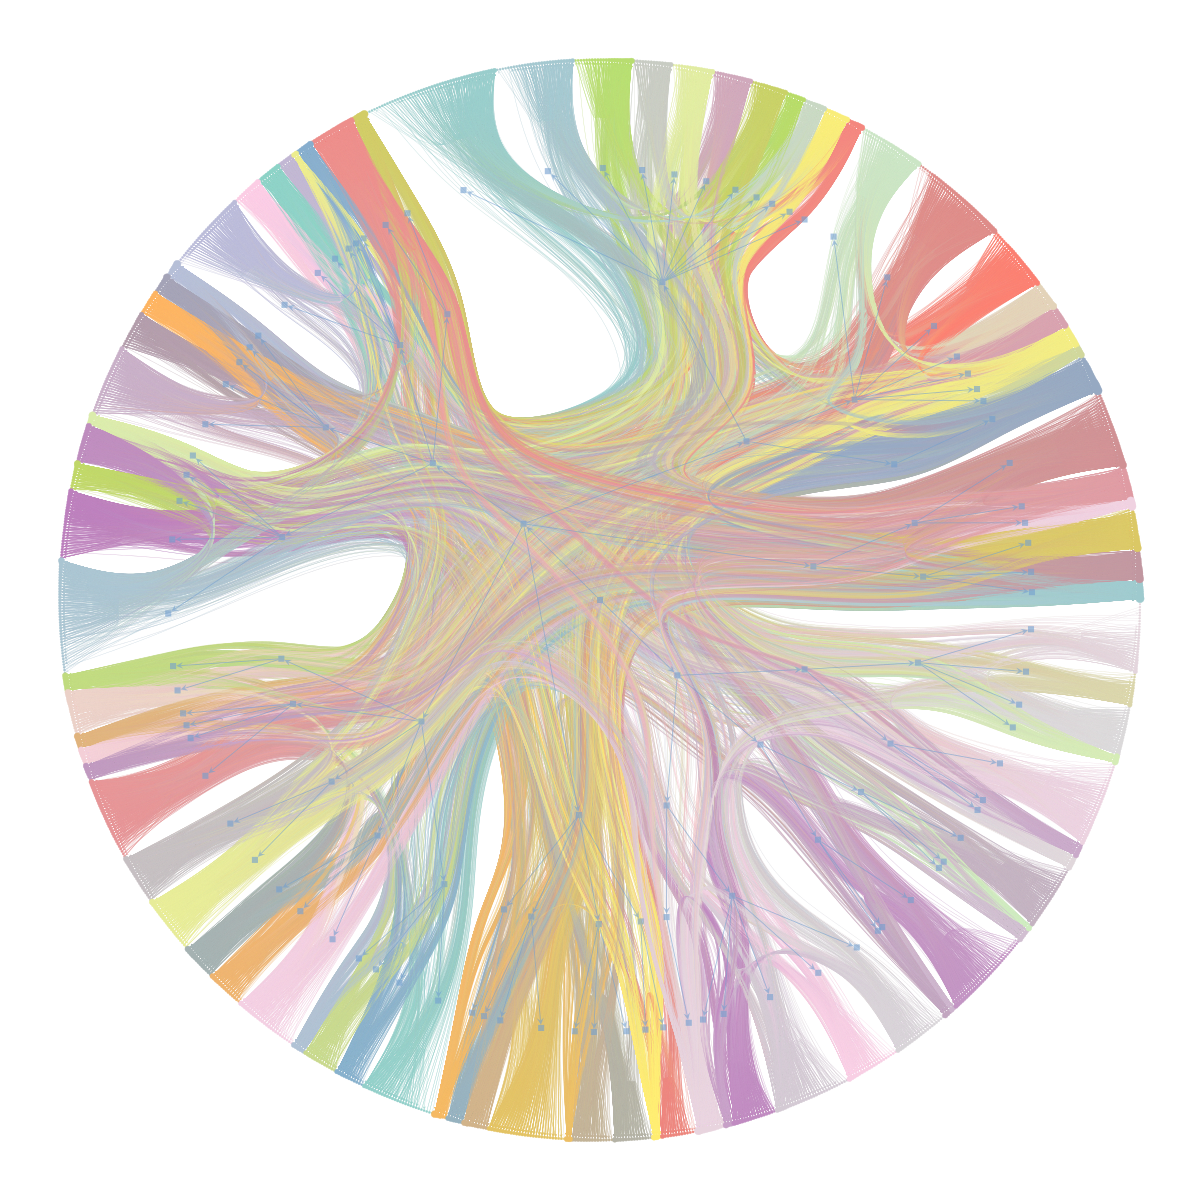

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1713b4550, at 0x1723e7160>,
 <Graph object, directed, with 1328 vertices and 1327 edges, at 0x1713b4940>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x1713b4940, at 0x17130dd00>)

In [33]:
# plot hdcSBM
state3.draw()

In [34]:
# Show levels with node and block informatio
state3.print_summary()

l: 0, N: 1207, B: 86
l: 1, N: 86, B: 24
l: 2, N: 24, B: 8
l: 3, N: 8, B: 2
l: 4, N: 2, B: 1


In [40]:
# Show blockstate info
levels3 = state3.get_levels()
for s in levels3:
    print(s)

<BlockState object with 86 blocks (86 nonempty), degree-corrected, for graph <Graph object, directed, with 1207 vertices and 52165 edges, 9 internal vertex properties, 2 internal graph properties, at 0x1713b4550>, at 0x1723d7490>
<BlockState object with 24 blocks (24 nonempty), for graph <Graph object, directed, with 86 vertices and 4428 edges, 2 internal vertex properties, 1 internal edge property, at 0x1723d4820>, at 0x1713dbdc0>
<BlockState object with 8 blocks (8 nonempty), for graph <Graph object, directed, with 24 vertices and 540 edges, 2 internal vertex properties, 1 internal edge property, at 0x1712fa430>, at 0x17147a5b0>
<BlockState object with 2 blocks (2 nonempty), for graph <Graph object, directed, with 8 vertices and 64 edges, 2 internal vertex properties, 1 internal edge property, at 0x1723d4670>, at 0x170f3ebb0>
<BlockState object with 1 blocks (1 nonempty), for graph <Graph object, directed, with 2 vertices and 4 edges, 2 internal vertex properties, 1 internal edge pro